I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [5]:
# targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

# ----------------Locally load data
targets = pd.read_csv('./Data/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [6]:
train_dtypes = {"session_id": pl.Int64,"elapsed_time": pl.Int64,"event_name": pl.Categorical,
                "name": pl.Categorical,"level": pl.Int8,"page": pl.Float32,
                "room_coor_x": pl.Float32,"room_coor_y": pl.Float32,"screen_coor_x": pl.Float32,
                "screen_coor_y": pl.Float32,"hover_duration": pl.Float32,"text": pl.Utf8,
                "fqid": pl.Utf8,"room_fqid": pl.Categorical,"text_fqid": pl.Utf8,
                "fullscreen": pl.Int8,"hq": pl.Int8,"music": pl.Int8,"level_group": pl.Categorical
               }

In [7]:
time_up_lim = 3.6e6 # 1 hour. events longer than 1 hour are outliers.
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, time_up_lim)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col("hover_duration").fill_null(0).clip(0, time_up_lim)
]

In [8]:
%%time

# we prepare the dataset for the training by level :
"""df = (pl.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))"""
#df = reduce_mem_usage_pl(df)

# ----------------Locally load data
df = (pl.read_csv("./Data/train.csv", dtypes=train_dtypes)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

print(f'df loaded with shape: {df.shape}')

df loaded with shape: (26296946, 18)
CPU times: user 29.7 s, sys: 11.3 s, total: 41.1 s
Wall time: 8.15 s


In [9]:
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

print(f'df1 loaded with shape: {df1.shape}')
print(f'df2 loaded with shape: {df2.shape}')
print(f'df3 loaded with shape: {df3.shape}')

df1 loaded with shape: (3981005, 18)
df2 loaded with shape: (8844238, 18)
df3 loaded with shape: (13471703, 18)


In [10]:
temp = pd.read_csv('./fqid_text_interact1.csv')
fqid_text_interaction1 = [[b_, a_] for b_, a_ in zip(temp['fqid'], temp['text_fqid'])]
temp = pd.read_csv('./fqid_text_interact2.csv')
fqid_text_interaction2 = [[b_, a_] for b_, a_ in zip(temp['fqid'], temp['text_fqid'])]
temp = pd.read_csv('./fqid_text_interact3.csv')
fqid_text_interaction3 = [[b_, a_] for b_, a_ in zip(temp['fqid'], temp['text_fqid'])]

fqid_text_interaction_raw = fqid_text_interaction1 + fqid_text_interaction2 + fqid_text_interaction3
print(len(fqid_text_interaction_raw))
fqid_text_interaction = []
for x in fqid_text_interaction_raw:
    if x not in fqid_text_interaction:
        fqid_text_interaction.append(x)
print(len(fqid_text_interaction))

116
109


In [11]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

combined_name_feature = [['checkpoint', 'basic'], 
['cutscene_click', 'basic'], 
['map_click', 'basic'], 
['map_click', 'close'],
['map_click', 'undefined'], 
['navigate_click', 'undefined'], 
['notebook_click', 'basic'], 
['notebook_click', 'close'],
['notebook_click', 'next'], 
['notebook_click', 'open'],
['notebook_click', 'prev'], 
['notification_click', 'basic'], 
['object_click', 'basic'], 
['object_click', 'close'], 
['observation_click', 'basic'], 
['person_click', 'basic'],
]

hover_event =[
['map_hover', 'basic'], 
['object_hover', 'basic'], 
['object_hover', 'undefined'], 
]

notebook_event = [
['notebook_click', 'basic'], 
['notebook_click', 'close'],
['notebook_click', 'next'], 
['notebook_click', 'open'],
['notebook_click', 'prev'], 
]

NUMS = [ 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]


# ----------------From another Notebook https://www.kaggle.com/code/xiaosufrankhu/lgbm-train-infer-with-cpu
#DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']
DIALOGS = ['Gramps','myself', 'national movement', 'Wisconsin Wonders','Earth Day', '1916', 'cleaning', 'cleaner', 'slip', 'jersey', 'Theodora Youmans', 'suffragist', 'that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']

room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [12]:
def feature_engineer(x, grp, use_extra, feature_suffix):
        
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.25).alias(f"{c}_q25_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(.75).alias(f"{c}_q75_{feature_suffix}") for c in NUMS],

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.25).alias(f'word_q25_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).quantile(.75).alias(f'word_q75_{c}') for c in DIALOGS],

        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).mean().alias(f"{c[0]+'_'+c[1]}_ET_mean_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).std().alias(f"{c[0]+'_'+c[1]}_ET_std_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).median().alias(f"{c[0]+'_'+c[1]}_ET_median_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.25).alias(f"{c[0]+'_'+c[1]}_ET_q25_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.75).alias(f"{c[0]+'_'+c[1]}_ET_q75_{feature_suffix}") for c in combined_name_feature],
        *[pl.col("elapsed_time_diff").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).sum().alias(f"{c[0]+'_'+c[1]}_ET_sum_{feature_suffix}") for c in combined_name_feature],
        
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).mean().alias(f"{c[0]+'_'+c[1]}_hover_mean_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).std().alias(f"{c[0]+'_'+c[1]}_hover_std_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).median().alias(f"{c[0]+'_'+c[1]}_hover_median_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.25).alias(f"{c[0]+'_'+c[1]}_hover_q25_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).quantile(.75).alias(f"{c[0]+'_'+c[1]}_hover_q75_{feature_suffix}") for c in hover_event],
        *[pl.col("hover_duration").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).sum().alias(f"{c[0]+'_'+c[1]}_hover_sum_{feature_suffix}") for c in hover_event],

        *[pl.col("page").filter((pl.col("event_name") == c[0]) & (pl.col("name") == c[1])).n_unique().alias(f"{c[0]+'_'+c[1]}_page_count_{feature_suffix}") for c in notebook_event],

        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in LEVELS],

        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in level_groups],

        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in text_lists],

        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in fqid_lists],

        *[pl.col("fqid").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).count().alias(f"{c[0]+'_'+c[1]}_fqid_counts{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).std().alias(f"{c[0]+'_'+c[1]}_ET_std_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).mean().alias(f"{c[0]+'_'+c[1]}_ET_mean_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).sum().alias(f"{c[0]+'_'+c[1]}_ET_sum_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).median().alias(f"{c[0]+'_'+c[1]}_ET_median_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).quantile(.25).alias(f"{c[0]+'_'+c[1]}_ET_q25_{feature_suffix}") for c in fqid_text_interaction],
        *[pl.col("elapsed_time_diff").filter((pl.col("fqid") == c[0]) & (pl.col("text_fqid") == c[1])).quantile(.75).alias(f"{c[0]+'_'+c[1]}_ET_q75_{feature_suffix}") for c in fqid_text_interaction],
        
        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_ET_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_ET_q75_{feature_suffix}") for c in room_lists],
        
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).std().alias(f"{c}_coord1_std_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_coord1_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).median().alias(f"{c}_coord1_median_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_coord1_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_coord1_q75_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).min().alias(f"{c}_coord1_min_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_x").filter(pl.col("room_fqid") == c).max().alias(f"{c}_coord1_max_{feature_suffix}") for c in room_lists],

        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).std().alias(f"{c}_coord2_std_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_coord2_mean_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).median().alias(f"{c}_coord2_median_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).quantile(.25).alias(f"{c}_coord2_q25_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).quantile(.75).alias(f"{c}_coord2_q75_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).min().alias(f"{c}_coord2_min_{feature_suffix}") for c in room_lists],
        *[pl.col("room_coor_y").filter(pl.col("room_fqid") == c).max().alias(f"{c}_coord2_max_{feature_suffix}") for c in room_lists],
    ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25)).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.quantile(.75)-s.quantile(.25) if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [13]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print(f'df1 done with shape: {df1.shape}')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print(f'df2 done with shape: {df2.shape}')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print(f'df3 done with shape: {df3.shape}')

df1 done with shape: (23562, 3225)
df2 done with shape: (23562, 3231)
df3 done with shape: (23562, 3229)
CPU times: user 9min 22s, sys: 9.1 s, total: 9min 31s
Wall time: 1min 30s


In [14]:
#-----------------------Break Session ID into different terms e.g. year, month, day, hour
def time_feature(train):
    
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)

    return train


df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

Remove some redundant features

In [15]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1.columns:
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

2222 1687 1458
hover_duration_median_
hover_duration_q25_
hover_duration_q75_
word_myself
word_national movement
word_Earth Day
word_cleaning
word_cleaner
word_Theodora Youmans
word_suffragist
word_found
word_wells
word_Oh
word_flag
notebook_click_next_page_count_
notebook_click_prev_page_count_
boss_tunic.capitol_0.hall.boss.talktogramps_fqid_counts
boss_tunic.capitol_1.hall.boss.haveyougotit_fqid_counts
chap2_finale_c_tunic.capitol_1.hall.chap2_finale_c_fqid_counts
block_0_tunic.drycleaner.frontdesk.block_0_fqid_counts
block_1_tunic.drycleaner.frontdesk.block_1_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.done_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.done2_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.hub_fqid_counts
worker_tunic.drycleaner.frontdesk.worker.takealook_fqid_counts
door_block_clean_tunic.historicalsociety.closet_dirty.door_block_clean_fqid_counts
door_block_talk_tunic.historicalsociety.closet_dirty.door_block_talk_fqid_counts
gramps_tunic.hist

In [16]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [17]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 895 1468 1701 features
We will train with 23562 users info


In [18]:
# Make a train_test_split for a test set which will be used for feature engineering

total_train_idx,total_test_idx,_,_ = train_test_split(ALL_USERS, np.zeros((len(ALL_USERS),1)), test_size=0.2, random_state=42)
# train_idx, test_idx

df1_train, df1_test = df1.loc[total_train_idx], df1.loc[total_test_idx]
df2_train, df2_test = df2.loc[total_train_idx], df2.loc[total_test_idx]
df3_train, df3_test = df3.loc[total_train_idx], df3.loc[total_test_idx]

In [22]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(total_train_idx),18)), index=total_train_idx, columns=[f'meta_{i}' for i in range(1, 19)])

#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_train
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2_train
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3_train
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.001,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 100,
        'subsample':0.7,
        'colsample_bytree': 0.5,
        'seed': 42
    }


    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, val_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[val_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL
        # clf.save_model(f'XGB_question{t}_fold{i}.xgb')

        # PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]



    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    feature_importance_df.to_csv(f'feature_importance_question{t}.csv')
    display(feature_importance_df.head(10))


#########################
### question 1 with features 895
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
cutscene_click_basic_ET_median_,0.008972
chap1_finale_c_ET_sum_,0.007329
checkpoint_basic_ET_sum_,0.007197
tunic.historicalsociety.collection_room_fqid_counts,0.006779
tunic.historicalsociety.collection.cs_ET_median_,0.006320
word_q25_you,0.005626
plaque_ET_sum_,0.005477
word_median_you,0.005472
cs_tunic.historicalsociety.collection.cs_ET_median_,0.005399


#########################
### question 2 with features 895
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
checkpoint_basic_ET_sum_,0.003520
word_median_help,0.003358
tunic.historicalsociety.collection_room_fqid_counts,0.003308
gramps_tunic.historicalsociety.collection.gramps.found_ET_q25_,0.003248
checkpoint_basic_ET_q75_,0.003230
tunic.historicalsociety.collection.gramps.found_ET_q25_,0.003183
word_q25_you,0.003067
session_number_,0.003032
word_mean_help,0.002936


#########################
### question 3 with features 895
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
tunic.historicalsociety.collection_room_fqid_counts,0.003171
session_number_,0.003141
checkpoint_basic_ET_sum_,0.003015
word_q75_you,0.002987
word_mean_you,0.002868
plaque_ET_sum_,0.002828
object_click_basic_ET_sum_,0.002717
chap1_finale_c_ET_sum_,0.002674
checkpoint_basic_ET_median_,0.002549


#########################
### question 4 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
person_click_basic_ET_q25_,0.018949
worker_ET_q25_,0.014120
word_q25_is,0.011995
word_q25_you,0.009346
worker_tunic.library.frontdesk.worker.wells_ET_median_,0.008935
tunic.library.frontdesk.worker.wells_ET_median_,0.008809
tunic.drycleaner.frontdesk.worker.hub_ET_q25_,0.008189
word_q25_the,0.008118
worker_tunic.drycleaner.frontdesk.worker.hub_ET_q25_,0.008040


#########################
### question 5 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
tunic.historicalsociety.stacks_room_fqid_counts,0.008090
session_number_,0.007828
text_fqid_unique_,0.005385
worker_ET_q25_,0.005047
journals_bingo_indexCount,0.004791
word_the,0.004422
tunic.historicalsociety.frontdesk_room_fqid_counts,0.004297
worker_tunic.humanecology.frontdesk.worker.intro_ET_q25_,0.003973
tunic.humanecology.frontdesk.worker.intro_ET_q25_,0.003745


#########################
### question 6 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.007738
tunic.historicalsociety.stacks_room_fqid_counts,0.006942
text_fqid_unique_,0.005965
11_ET_sum_,0.004732
journals_bingo_indexCount,0.004071
word_to,0.003275
word_the,0.003135
reader_bingo_indexCount,0.002791
tunic.library.microfiche_room_fqid_counts,0.002274


#########################
### question 7 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.006899
tunic.historicalsociety.stacks_room_fqid_counts,0.005194
tunic.historicalsociety.frontdesk_room_fqid_counts,0.004014
worker_ET_q25_,0.003443
word_the,0.003270
person_click_basic_ET_q25_,0.003081
word_to,0.003044
text_fqid_unique_,0.003040
tunic.library.frontdesk_room_fqid_counts,0.002673


#########################
### question 8 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.003472
word_to,0.002849
word_the,0.002727
room_fqid_unique_,0.002628
object_click_basic_ET_sum_,0.002201
tunic.historicalsociety.frontdesk_room_fqid_counts,0.002060
tunic.historicalsociety.stacks_room_fqid_counts,0.001936
word_q25_is,0.001892
person_click_basic_ET_q25_,0.001839


#########################
### question 9 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.008639
text_fqid_unique_,0.006453
word_to,0.005518
word_the,0.004450
tunic.historicalsociety.stacks_room_fqid_counts,0.004273
reader_bingo_indexCount,0.003074
journals_bingo_indexCount,0.002567
tunic.historicalsociety.frontdesk_room_fqid_counts,0.002333
worker_ET_q25_,0.002023


#########################
### question 10 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.008103
tunic.historicalsociety.stacks_room_fqid_counts,0.007031
journals_bingo_indexCount,0.004460
11_ET_sum_,0.003407
tunic.historicalsociety.frontdesk_room_fqid_counts,0.003327
person_click_basic_ET_q25_,0.003059
word_the,0.002816
reader_bingo_indexCount,0.002359
word_to,0.002352


#########################
### question 11 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.005739
tunic.historicalsociety.stacks_room_fqid_counts,0.004200
11_ET_sum_,0.003898
object_click_basic_ET_sum_,0.003231
journals_bingo_indexCount,0.002415
tunic.historicalsociety.frontdesk_room_fqid_counts,0.002171
map_hover_basic_ET_sum_,0.001960
reader_bingo_indexCount,0.001845
tunic.historicalsociety.stacks_ET_sum_,0.001785


#########################
### question 12 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.003578
tunic.historicalsociety.frontdesk_room_fqid_counts,0.002574
word_to,0.002101
word_the,0.002072
tunic.drycleaner.frontdesk_room_fqid_counts,0.001981
tunic.historicalsociety.stacks_room_fqid_counts,0.001945
map_hover_basic_ET_sum_,0.001692
word_q25_the,0.001657
reader_bingo_indexCount,0.001618


#########################
### question 13 with features 1468
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
object_click_basic_ET_sum_,0.008368
journals_bingo_indexCount,0.005148
object_hover_undefined_ET_sum_,0.004526
11_ET_sum_,0.003717
journals.pic_2.next_ET_sum_,0.003570
room_fqid_unique_,0.003508
tunic.historicalsociety.stacks_room_fqid_counts,0.003383
session_number_,0.002313
reader.paper1.next_ET_sum_,0.002298


#########################
### question 14 with features 1701
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
word_to,0.008763
session_number_,0.006866
word_the,0.004013
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.002744
tocloset_dirty_ET_std_,0.002724
tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.002716
room_fqid_unique_,0.002698
archivist_glasses_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_fqid_counts,0.002559
tunic.flaghouse.entry_room_fqid_counts,0.002537


#########################
### question 15 with features 1701
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
word_to,0.009563
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.007623
tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.007346
session_number_,0.005367
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_median_,0.003894
tunic.historicalsociety.entry.groupconvo_flag_ET_median_,0.003699
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,0.003252
flag_girl_tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,0.003206
tunic.library.frontdesk_ET_sum_,0.002919


#########################
### question 16 with features 1701
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
word_q75_the,0.001547
tunic.library.frontdesk.worker.nelson_ET_sum_,0.001390
word_median_need,0.001351
word_q75_is,0.001326
worker_tunic.library.frontdesk.worker.nelson_ET_sum_,0.001323
tunic.wildlife.center_room_fqid_counts,0.001321
word_q75_to,0.001283
screen_coor_x_q25_,0.001239
notification_click_basic_ET_median_,0.001234


#########################
### question 17 with features 1701
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
13-22_ET_sum_,0.003715
word_sum_flag,0.003416
tunic.wildlife.center_ET_sum_,0.002844
tunic.library.frontdesk_ET_sum_,0.002496
tunic.flaghouse.entry_ET_sum_,0.002399
19_ET_sum_,0.002291
20_ET_sum_,0.002099
word_mean_flag,0.001814
flag_girl_ET_sum_,0.001303


#########################
### question 18 with features 1701
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.002161
tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.001998
groupconvo_flag_tunic.historicalsociety.entry.groupconvo_flag_ET_q25_,0.001973
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.001801
archivist_glasses_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.001797
toentry_ET_sum_,0.001754
word_you,0.001671
tunic.historicalsociety.closet_dirty_ET_sum_,0.001657
tunic.flaghouse.entry_room_fqid_counts,0.001633


CPU times: user 2h 27min 37s, sys: 27.5 s, total: 2h 28min 5s
Wall time: 2h 14min 43s


0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

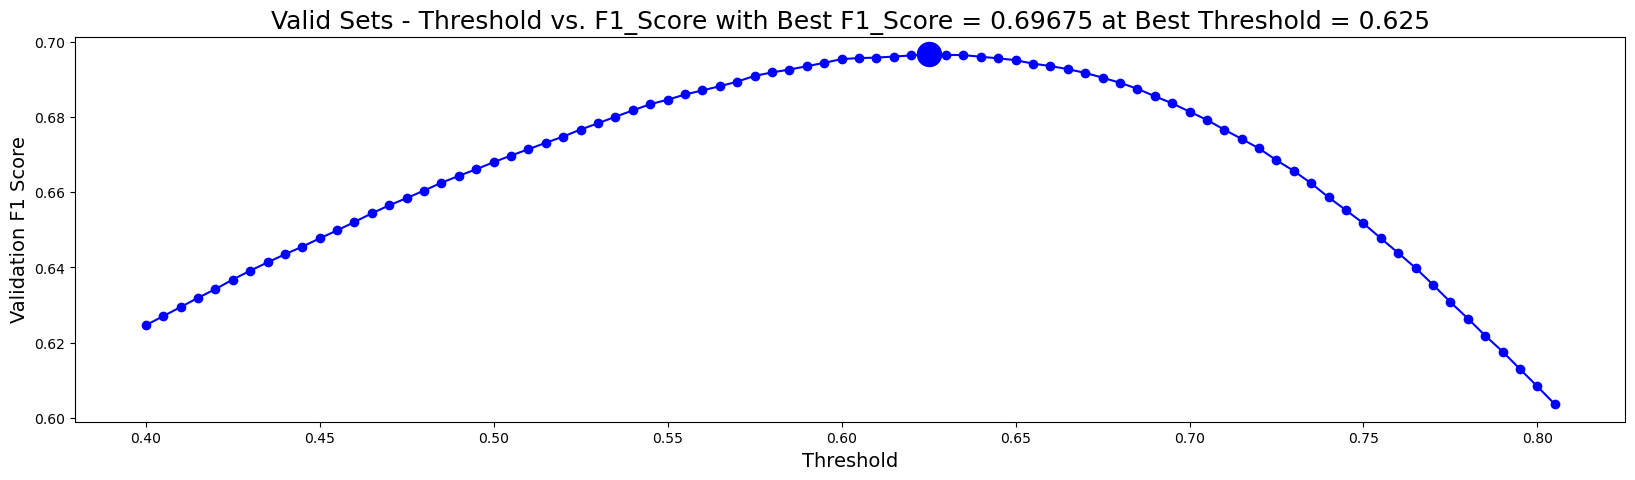

In [23]:
# For the valid data sets combined
true = oof_xgb.copy()

for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[total_train_idx]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Valid Sets - Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
# plt.savefig('BestThreshold.png')
plt.show()

In [27]:
# Print F1 Scores Question by Question
try:
    print('When using optimal threshold...')
    for k in range(1, 19):

        # COMPUTE F1 SCORE PER QUESTION
        m = f1_score(true[f'meta_{k}'].values, (oof_xgb[f'meta_{k}'].values>best_threshold_xgb).astype('int'), average='macro')
        print(f'Q{k}: F1 =',m)
        
except:
    print('Something went wrong.....')
""" Set all value to one and then get the macro f1 score
0.4211237500921308
0.49464879356568364
0.4829379622111523
0.4438989851309889
0.35411184210526314
0.43692197395148763
0.42398239823982403
0.3816559506626427
0.4240527988266927
0.3357390544388374
0.3915872646990472
0.46321904544936776
0.21575023299161228
0.4144050104384134
0.32479367262723524
0.42358783668077404
0.4075135787567894
0.48734796893017995
    """

When using optimal threshold...
Q1: F1 = 0.6753057979040903
Q2: F1 = 0.5109572139429108
Q3: F1 = 0.5175373855202181
Q4: F1 = 0.6809081555065832
Q5: F1 = 0.6371731450691543
Q6: F1 = 0.6445112851142355
Q7: F1 = 0.6315940861396491
Q8: F1 = 0.5676457724461803
Q9: F1 = 0.6306294159814878
Q10: F1 = 0.581343016420237
Q11: F1 = 0.6105425350680245
Q12: F1 = 0.5125995812627058
Q13: F1 = 0.46669258440603745
Q14: F1 = 0.6364937180167038
Q15: F1 = 0.6007548829433653
Q16: F1 = 0.48817576846633
Q17: F1 = 0.55366375254171
Q18: F1 = 0.49669718891339976


' Set all value to one and then get the macro f1 score\n0.4211237500921308\n0.49464879356568364\n0.4829379622111523\n0.4438989851309889\n0.35411184210526314\n0.43692197395148763\n0.42398239823982403\n0.3816559506626427\n0.4240527988266927\n0.3357390544388374\n0.3915872646990472\n0.46321904544936776\n0.21575023299161228\n0.4144050104384134\n0.32479367262723524\n0.42358783668077404\n0.4075135787567894\n0.48734796893017995\n    '

Now we use full data to retrain our models with the best iterations, and save them. 

In [28]:
# Save the best iteration_xgb variable
f_save = open('best_iteration_xgb.pkl', 'wb')
pickle.dump(best_iteration_xgb, f_save)
f_save.close()

In [29]:
# Train the model again with all data but selected features from the cross_val dump into pickle

feature_dict={}
for t in range(1,19):
    feat_tmp = pd.read_csv(f'./feature_importance_question{t}.csv')

    if t<=3: 
        feature_dict[str(t)] = feat_tmp.sort_values(by='mean', ascending=False).loc[1:250, 'feature']
        #feature_dict[str(t)]= feature_dict[str(t)].loc[feature_dict[str(t)].isin(FEATURES1)]
        
    elif t<=13: 
        feature_dict[str(t)] = feat_tmp.sort_values(by='mean', ascending=False).loc[1:800, 'feature']
        #feature_dict[str(t)]= feature_dict[str(t)].loc[feature_dict[str(t)].isin(FEATURES2)]

    elif t<=22:
        feature_dict[str(t)] = feat_tmp.sort_values(by='mean', ascending=False).loc[1:800, 'feature']
        #feature_dict[str(t)]= feature_dict[str(t)].loc[feature_dict[str(t)].isin(FEATURES3)]


f_save = open('importance_dict.pkl', 'wb')
pickle.dump(feature_dict, f_save)
f_save.close()

In [31]:
# Use all the data to train the final model

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_train
        FEATURES = feature_dict[str(t)]
    elif t<=13: 
        grp = '5-12'
        df = df2_train
        FEATURES = feature_dict[str(t)]
    elif t<=22: 
        grp = '13-22'
        df = df3_train
        FEATURES = feature_dict[str(t)]
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.001,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.7,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')
    
    print()

#########################
### question 4 features 800

#########################
### question 5 features 800

#########################
### question 6 features 800

#########################
### question 7 features 800

#########################
### question 8 features 800

#########################
### question 9 features 800

#########################
### question 10 features 800

#########################
### question 11 features 800

#########################
### question 12 features 800

#########################
### question 13 features 800

#########################
### question 14 features 800

#########################
### question 15 features 800

#########################
### question 16 features 800

#########################
### question 17 features 800

#########################
### question 18 features 800



We save features names as dict for each questions

In [32]:
# For the test set that were ruled out before training
# All zeros
test_xgb = pd.DataFrame(data=np.zeros((len(total_test_idx),18)), index=total_test_idx, columns=[f'meta_{i}' for i in range(1, 19)])

# Copy to store true value
true = test_xgb.copy()

for t in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==t].set_index('session').loc[total_test_idx]
    true[f'meta_{t}'] = tmp.correct.values

    # PREDICT THE PROBA OF LABELS
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_test
        FEATURES = feature_dict[str(t)]
    elif t<=13: 
        grp = '5-12'
        df = df2_test
        FEATURES = feature_dict[str(t)]
    elif t<=22: 
        grp = '13-22'
        df = df3_test
        FEATURES = feature_dict[str(t)]
    
    model = XGBClassifier()
    model.load_model(f'./XGB_question{t}.xgb')
    test_xgb.loc[total_test_idx, f'meta_{t}'] = model.predict_proba(df[FEATURES].astype('float32'))[:,1]
    # F1 Score for each question
    #qm = f1_score(true[f'meta_{t}'].values, model.predict_proba(df[FEATURES].astype('float32'))[:,1]>best_threshold_xgb.astype(int), average='macro')
    #print(f'The question{t} f1 score for the test set is: {qm}')
    
preds = (test_xgb.values.reshape((-1))>best_threshold_xgb).astype('int')
m = f1_score(true.values.reshape((-1)), preds, average='macro')   

print(f'The overall f1 score for the test set is: {m}')

The overall f1 score for the test set is: 0.6977894317436614


In [47]:
# FINALLY Train models with all the data for submission
# Use all the data to train the final model

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = feature_dict[str(t)]
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = feature_dict[str(t)]
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = feature_dict[str(t)]
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question_final{t}.xgb')
    
    print()

#########################
### question 1 features 250

#########################
### question 2 features 250

#########################
### question 3 features 250

#########################
### question 4 features 800

#########################
### question 5 features 800

#########################
### question 6 features 800

#########################
### question 7 features 800

#########################
### question 8 features 800

#########################
### question 9 features 800

#########################
### question 10 features 800

#########################
### question 11 features 800

#########################
### question 12 features 800

#########################
### question 13 features 800

#########################
### question 14 features 800

#########################
### question 15 features 800

#########################
### question 16 features 800

#########################
### question 17 features 800

#########################
### question 18 features 800

